In [1]:
import numpy as np
import serpentTools as st
from snapReactors.reactor_models.AutomatedSerpentModels.GCU.c3_radial_sens_2d.utilitities import*
import os
from numpy.linalg import norm
import matplotlib.image as mpimg

In [2]:
ringresFile = '/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c2_1.main_res.m'
ringres = st.read(ringresFile, reader='results')

SERPENT Serpent 2.2.1 found in /Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c2_1.main_res.m, but version 2.1.31 is defined in settings
  Attemping to read anyway. Please report strange behaviors/failures to developers.


### System Analysis

In [3]:
# coreUni = ringres.universes['100', 0, 0, 0]
rootUni = ringres.universes['0', 0, 0, 0]

In [4]:
# rootUni.infExp.keys()

In [5]:
# ax = rootUni.plot('infTot', labels=['infAbs - system'])
# ax.grid()
# coreUni.plot('infTot', ax=ax, labels = ['infAbs - core'], legend='right')

In [6]:
def condense(universe, key, useInvFlux = False):
    cond = None
    if useInvFlux:
        invFlux = np.zeros(len(universe.infExp[key]))
        for i in range(0, len(invFlux)):
            invFlux[i] = 1/universe.infExp[key][i]
        cond = np.sum(np.multiply(universe.infExp[key], invFlux)/np.sum(invFlux))
    else:
        cond = np.sum(np.multiply(universe.infExp[key], universe.infExp['infFlx']))/np.sum(universe.infExp['infFlx'])
    return cond

In [7]:
fluxweight_coreTranspxs = condense(rootUni, 'infTranspxs')
invfluxweight_coreTranspxs = condense(rootUni, 'infTranspxs', useInvFlux=True)

fluxweight_coreDiff = 1/(3*fluxweight_coreTranspxs)
invfluxweight_coreDiff = 1/(3*invfluxweight_coreTranspxs)

print("fluxweighted infTranspxs : {:.3f}".format(fluxweight_coreTranspxs))
print("invfluxweighted infTranspxs mfp : {:.3f}".format(1/invfluxweight_coreTranspxs))

print("fluxweighted infDiff : {:.3f}".format(fluxweight_coreDiff))
print("invfluxweighted infDiff : {:.3f}".format(invfluxweight_coreDiff))

coreAbs = condense(rootUni, 'infAbs')

fluxweight_coreDiffLen = np.sqrt(fluxweight_coreDiff/coreAbs)
invfluxweight_coreDiffLen = np.sqrt(invfluxweight_coreDiff/coreAbs)

print("fluxweighted infAbs mfp : {:.3f}".format(1/coreAbs))

print("fluxweighted infDiffLen : {:.3f}".format(fluxweight_coreDiffLen))
print("invfluxweighted infDiffLen : {:.3f}".format(invfluxweight_coreDiffLen))  

fluxweighted infTranspxs : 0.488
invfluxweighted infTranspxs mfp : 2.995
fluxweighted infDiff : 0.684
invfluxweighted infDiff : 0.998
fluxweighted infAbs mfp : 55.211
fluxweighted infDiffLen : 6.143
invfluxweighted infDiffLen : 7.424


In [8]:
hisRes = st.read('/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c2.main_his0.m')

In [9]:
hisRes.arrays.keys()

dict_keys(['time', 'impKeff', 'anaKeff', 'colKeff', 'iterVal', 'meanPopSize', 'meanPopWgt', 'transportRuntime', 'transportCpuUsage', 'entrSpt', 'entrSwg'])

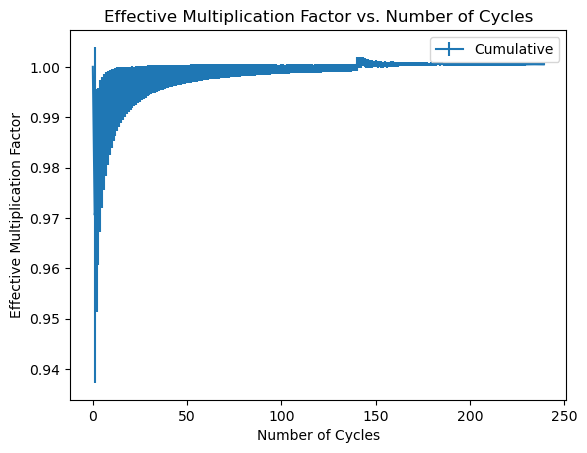

In [10]:
hKeff = hisRes['anaKeff']
hKu = hKeff[:, 2] * 3 * hKeff[:, 1]
cyc = np.arange(hKu.shape[0])
#plt.plot(cyc, hKeff[:, 0], label="Cycle")
plt.title("Effective Multiplication Factor vs. Number of Cycles")
plt.xlabel("Number of Cycles")
plt.ylabel("Effective Multiplication Factor")
plt.errorbar(cyc, hKeff[:, 1], yerr=hKu, label="Cumulative")
plt.legend()

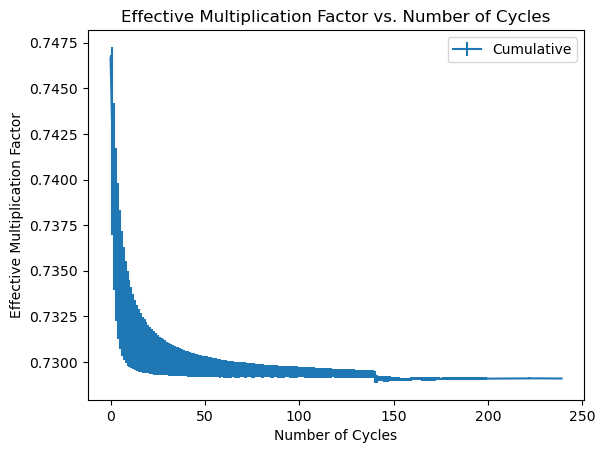

In [11]:
hKeff = hisRes['entrSwg']
hKu = hKeff[:, 2] * 3 * hKeff[:, 1]
cyc = np.arange(hKu.shape[0])
#plt.plot(cyc, hKeff[:, 0], label="Cycle")
plt.title("Effective Multiplication Factor vs. Number of Cycles")
plt.xlabel("Number of Cycles")
plt.ylabel("Effective Multiplication Factor")
plt.errorbar(cyc, hKeff[:, 1], yerr=hKu, label="Cumulative")
plt.legend()

In [14]:
def kToPCM(k):
    return 1e5*((k-1)/k)

### Radial GCU Resolution Study 2D

####  Make Sure Cases are unbiased torwards statistics on few-group data

In [15]:
maxs = []
max = None
maxunis = []
for uni in ringres.universes:
    maxs.append(np.max(ringres.universes[uni].infUnc['infTot']))
    maxunis.append(uni)
print(maxunis[np.where(maxs == np.max(maxs))[0][0] ], np.max(maxs))

UnivTuple(universe='6900', burnup=0, step=0, days=0) 0.02215


#### Keff Comparison

In [16]:
reffKeff = ringres.resdata['absKeff']
print("Reference Serpent Keff: {:.6}, pcm: {}".format(reffKeff[0],reffKeff[1]*1e5))
print("Reference Serpent Excess Reactivity : {:.6}".format(kToPCM(reffKeff[0])))

Reference Serpent Keff: 1.00049, pcm: 6.6000000000000005
Reference Serpent Excess Reactivity : 48.976


In [17]:
rho_exp = 111
print("Reference Serpent Excess Reactivity Discrepency With Experiment: {:.6}".format(kToPCM(reffKeff[0]) - rho_exp))

Reference Serpent Excess Reactivity Discrepency With Experiment: -62.024


In [19]:
ringResDF = postProcess('/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c2_csv.csv', isSteady=True)

In [20]:
griff_rkeff = ringResDF['eigenvalue'][1]

print("ring resolution keff: {:.5f}, pcmDiff: {:.1f}".format(griff_rkeff, kToPCM(griff_rkeff) - kToPCM(reffKeff[0])))
print("griffin Excess Reactivity : {:.6}".format(kToPCM(griff_rkeff)))

ring resolution keff: 1.00148, pcmDiff: 98.6
griffin Excess Reactivity : 147.596


In [21]:
print(" Griffin Excess Reactivity Discrepency With Experiment: {:.6}".format(kToPCM(griff_rkeff) - rho_exp))

 Griffin Excess Reactivity Discrepency With Experiment: 36.596


1. PCM difference decreases with increase in spatial resolution as espected

#### Verification of Few Group Spectrum

In [22]:
fgs_hr18 = [5.0000E-09, 2.5000E-08, 1.0000E-07, 4.0000E-07, 9.9600E-07, 3.0000E-06,
9.8770E-06, 2.7700E-05, 1.0000E-04, 5.5000E-04, 3.0000E-03, 1.5030E-02,
1.0000E-01, 4.0000E-01, 8.2100E-01, 1.3530E+00, 3.0000E+00, 6.0655E+00,
2.0000E+01]

In [23]:
refFGSFile = '/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c2.main_det0.m'
refFGSDet = st.read(refFGSFile)
refFGS = refFGSDet['fgsdet']

In [31]:
def calcL2NormDiffPerc(ref,  comp):
    diff = np.subtract(ref, comp)
    diffNorm  = norm(diff)
    base = norm(ref)
    return (diffNorm/base)*100

def calcPercentRelativeError(ref, comp):
    relErr = []
    diff = np.abs(np.subtract(ref, comp))

    for i in range(0, len(diff)):
        if (diff[i] !=0 ) & (ref[i] !=0) :
            #relErr.append(2*(diff[i]/(np.abs(ref[i])+np.abs(comp[i]))))
            relErr.append(100*diff[i]/ref[i])
        elif (diff[i] == 0):
            maxRef = np.max(ref)
            relErr.append(0)
        else:
            maxRef = np.max(ref)
            relErr.append(100*diff[i]/maxRef)
        #print("diff: {:.2f}, comp: {:.2f}, ref: {:.2f}, relerror: {:.2f}".format(diff[i], comp[i], ref[i], relErr[i]))

    return relErr

In [32]:
def normZeroToOne(arr):
    normArr = np.zeros(len(arr))
    min = np.min(arr)
    max = np.max(arr)
    for i in range(0, len(arr)):
        normArr[i] = (arr[i] - min)/(max - min)
    return normArr

In [33]:
def normMaximum(arr):
    normArr = np.zeros(len(arr))
    max = np.max(arr)
    for i in range(0, len(arr)):
        normArr[i] = (arr[i])/(max)
        
    return normArr

In [34]:
normRefFGS = normMaximum(refFGS.tallies)

In [35]:
# plt.stairs(normRefFGS)

In [36]:
#collectFGS
nFewGroups = 18

griff_ringResFGS = []

for i in range(nFewGroups-1, -1, -1):
    griff_ringResFGS.append(ringResDF['Flux{}'.format(i+1)][1])


normGriff_ringResFGS = normMaximum(griff_ringResFGS)


In [37]:
groupBins = np.linspace(0, 18, 19).astype("int")
print(groupBins)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]


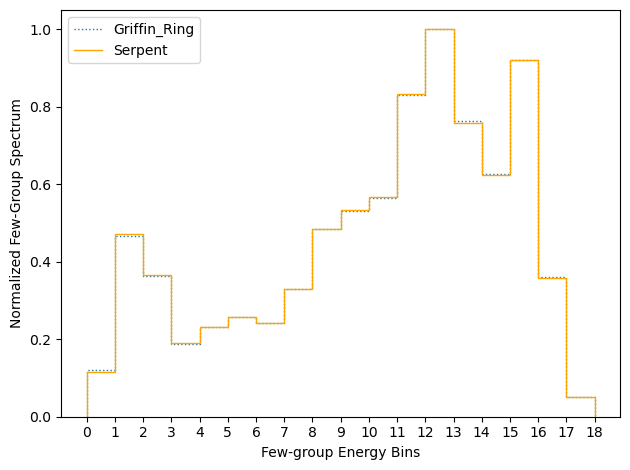

In [38]:

plt.stairs(normGriff_ringResFGS, groupBins, label = "Griffin_Ring", linewidth = 1, alpha = 1, linestyle = ":")
plt.stairs(normRefFGS, groupBins, label = "Serpent", color = "orange", linewidth = 1, alpha = 1)
plt.xticks(groupBins)
plt.xlabel("Few-group Energy Bins")
plt.ylabel("Normalized Few-Group Spectrum")
plt.legend(loc='upper left')
plt.tight_layout()
#plt.grid()

In [39]:
ringRelError = calcPercentRelativeError(normRefFGS, normGriff_ringResFGS)
print(np.max(ringRelError))

5.686446418840881


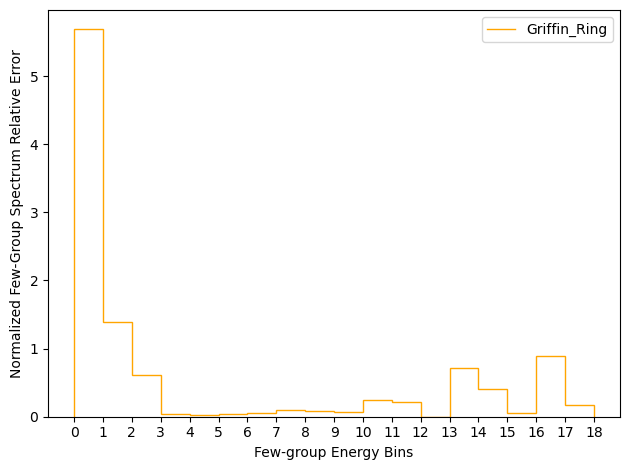

In [40]:

plt.stairs(ringRelError, groupBins, label = "Griffin_Ring", linewidth = 1, alpha = 1, color = "orange")
plt.xticks(groupBins)
plt.xlabel("Few-group Energy Bins")
plt.ylabel("Normalized Few-Group Spectrum Relative Error")
plt.legend(loc='upper right')
plt.tight_layout()

In [41]:
def calcL2NormDiffPerc(ref,  comp):
    diff = np.subtract(ref, comp)
    diffNorm  = norm(diff)
    base = norm(ref)
    return (diffNorm/base)*100

def calcPercentRelativeError(ref, comp):
    relErr = []
    diff = np.abs(np.subtract(ref, comp))

    for i in range(0, len(diff)):
        if (diff[i] !=0 ) & (ref[i] !=0) :
            #relErr.append(2*(diff[i]/(np.abs(ref[i])+np.abs(comp[i]))))
            relErr.append(100*diff[i]/ref[i])
        elif (diff[i] == 0):
            maxRef = np.max(ref)
            relErr.append(0)
        else:
            maxRef = np.max(ref)
            relErr.append(100*diff[i]/maxRef)
        #print("diff: {:.2f}, comp: {:.2f}, ref: {:.2f}, relerror: {:.2f}".format(diff[i], comp[i], ref[i], relErr[i]))

    return relErr

In [42]:
ringL2NormDiffFGS = calcL2NormDiffPerc(normRefFGS, normGriff_ringResFGS)

In [43]:
print("ring resolution FGS l2normDiff (%): {:.3f}".format(ringL2NormDiffFGS))

ring resolution FGS l2normDiff (%): 0.527


#### Flux Map Comparison

In [44]:
ringRefMapFile = '/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c2.main_det0.m'
ringRefMapDet = st.read(ringRefMapFile, reader='det')

In [45]:
def griffinFluxMapReader(path):
    keys = ['volume', 'nufiss', 'power', 'absorption', 'scalar']
    block = []
    vol = []
    nufiss = []
    pow = []
    abs = []
    scalar = []
    with open(path, "r") as f:
        lines = f.readlines()
        f.close()

    bidx = None
    eidx = None
    hasBegun = False
    for ldx, line in enumerate(lines):
        if "Block average" in line:
            bidx = ldx+2
            hasBegun = True 
        if (line == "\n") & hasBegun:
            eidx = ldx
            break
    
    data = lines[bidx:eidx]

    dicts = []

    for i in range(0, len(data)):
        vals  = data[i].split()
        block.append(vals[0])
        vol.append(float(vals[1]))
        nufiss.append(float(vals[2]))
        pow.append(float(vals[3]))
        abs.append(float(vals[4]))
        scalar.append(float(vals[5]))

        dset = [vol[i], nufiss[i], pow[i], abs[i], scalar[i]]
        dicts.append(dict(zip(keys, dset)))


    map = dict(zip(block, dicts))
    return map

In [68]:
ringGriffBlockMap = griffinFluxMapReader('/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/c2_flux_map.txt')

In [69]:
ringGriffBlockMap

{'9': {'volume': 1329.057248,
  'nufiss': 0.0,
  'power': 0.0,
  'absorption': 9.009039e-08,
  'scalar': 0.009725548},
 '20': {'volume': 651.948459,
  'nufiss': 0.0,
  'power': 0.0,
  'absorption': 5.596877e-09,
  'scalar': 0.0006798903},
 '40': {'volume': 716.518434,
  'nufiss': 0.0,
  'power': 0.0,
  'absorption': 5.839352e-09,
  'scalar': 0.0006999058},
 '71': {'volume': 36.956005,
  'nufiss': 0.0003793871,
  'power': 5.052225e-15,
  'absorption': 0.0002275734,
  'scalar': 0.006943023},
 '72': {'volume': 63.353152,
  'nufiss': 0.000370946,
  'power': 4.939837e-15,
  'absorption': 0.0002224945,
  'scalar': 0.006766251},
 '73': {'volume': 95.029728,
  'nufiss': 0.0003576228,
  'power': 4.762471e-15,
  'absorption': 0.00021432,
  'scalar': 0.006491245},
 '74': {'volume': 126.706304,
  'nufiss': 0.000339519,
  'power': 4.521515e-15,
  'absorption': 0.0002034011,
  'scalar': 0.006119657},
 '75': {'volume': 158.382879,
  'nufiss': 0.0003203068,
  'power': 4.265853e-15,
  'absorption': 0.0

In [70]:
def getBlock2UniMap(df, blockMap):
    uniMap = {}
    blocks = list(df['Block Name'])
    unis = list(df['material_id'])

    bkeyu = {}

    for bdx, block in enumerate(blocks):
        bkeyu[block.replace("block_", "")] = str(int(unis[bdx]))
        #print(unis[bdx])

    for block in blockMap:
        uniMap[bkeyu[block]] = blockMap[block]
    
    return uniMap, bkeyu

In [71]:
def getUni2BlockMap(df, uniMap):
    blockMap = {}

    blocks = list(df['Block Name'])
    unis = list(df['material_id'])

    ukeyb = {}

    for bdx, block in enumerate(blocks):
        ukeyb[str(int(unis[bdx]))] = block.replace("block_", "")

    for uni in uniMap:
        # uniMap[bkeyu[block]] = blockMap[block]

        blockMap[ukeyb[uni]] = uniMap[str(uni)]
    return blockMap, ukeyb

In [72]:
ringCellData = pd.read_csv('/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c2_cellData.csv')


In [73]:
ringGriffMap, bkeyu = getBlock2UniMap(ringCellData, ringGriffBlockMap)

In [74]:
print(bkeyu)

{'9': '900', '20': '8000', '40': '7500', '71': '2100', '72': '2200', '73': '2300', '74': '2400', '75': '2500', '76': '2600', '77': '2700', '78': '2800', '79': '3100', '81': '1100', '82': '1200', '83': '1300', '84': '1400', '85': '1500', '86': '1600', '87': '1700', '88': '1800', '89': '2000', '101': '101', '102': '201', '103': '301', '104': '401', '105': '501', '106': '601', '107': '701', '108': '801', '124': '7000', '125': '7100', '126': '7200', '127': '7300', '128': '7400', '133': '6500', '134': '6600', '135': '6700', '136': '6800', '137': '6900', '201': '102', '202': '202', '203': '302', '204': '402', '205': '502', '206': '602', '207': '702', '208': '802', '210': '9400', '251': '9100', '301': '103', '302': '203', '303': '303', '304': '403', '305': '503', '306': '603', '307': '703', '308': '803', '340': '9500', '401': '104', '402': '204', '403': '304', '404': '404', '405': '504', '406': '604', '407': '704', '408': '804', '410': '9300', '501': '105', '502': '205', '503': '305', '504': 

In [75]:
# print(coreGriffMap)
# print(ringGriffMap)
# print(elemGriffMap)

In [76]:

ringUnis = list(ringGriffMap.keys())


# print(createDetectors(coreUnis))
# print(createDetectors(ringUnis))
# print(createDetectors(elemUnis))

In [77]:
def getUniValsList(map, attr):
    vals = []
    for uni in map:
        vals.append(map[uni][attr])
    return vals

In [78]:
coreNuFissMap = {}
coreCapMap = {}

coreNuFiss = []
coreCap = []

ringNuFissMap = {}
ringCapMap = {}

ringNuFiss = []
ringCap = []

elemNuFissMap = {}
elemCapMap = {}

elemNuFiss = []
elemCap = []



for uni in ringUnis:
    ringNuFissMap[uni] = ringRefMapDet["nuFissRate{}".format(uni)]
    ringCapMap[uni] = ringRefMapDet["scalarFlux{}".format(uni)]



In [79]:

for uni in ringNuFissMap:
    ringNuFiss.append(ringNuFissMap[uni].tallies/ringGriffMap[uni]['volume'])
    ringCap.append(ringCapMap[uni].tallies/ringGriffMap[uni]['volume'])

In [80]:

griffRingNuFiss = getUniValsList(ringGriffMap, 'nufiss')
griffRingScalar = getUniValsList(ringGriffMap, 'scalar')

In [81]:
ringNuFissMap

{'900': <serpentTools.detectors.Detector at 0x7fab53fcdfa0>,
 '8000': <serpentTools.detectors.Detector at 0x7fab5421b850>,
 '7500': <serpentTools.detectors.Detector at 0x7fab54274460>,
 '2100': <serpentTools.detectors.Detector at 0x7fab54274160>,
 '2200': <serpentTools.detectors.Detector at 0x7fab54274130>,
 '2300': <serpentTools.detectors.Detector at 0x7fab54274100>,
 '2400': <serpentTools.detectors.Detector at 0x7fab542740d0>,
 '2500': <serpentTools.detectors.Detector at 0x7fab542740a0>,
 '2600': <serpentTools.detectors.Detector at 0x7fab54274040>,
 '2700': <serpentTools.detectors.Detector at 0x7fab54269cd0>,
 '2800': <serpentTools.detectors.Detector at 0x7fab54274190>,
 '3100': <serpentTools.detectors.Detector at 0x7fab54269fa0>,
 '1100': <serpentTools.detectors.Detector at 0x7fab5422fdf0>,
 '1200': <serpentTools.detectors.Detector at 0x7fab5422f340>,
 '1300': <serpentTools.detectors.Detector at 0x7fab5422f310>,
 '1400': <serpentTools.detectors.Detector at 0x7fab5422f2b0>,
 '1500': 

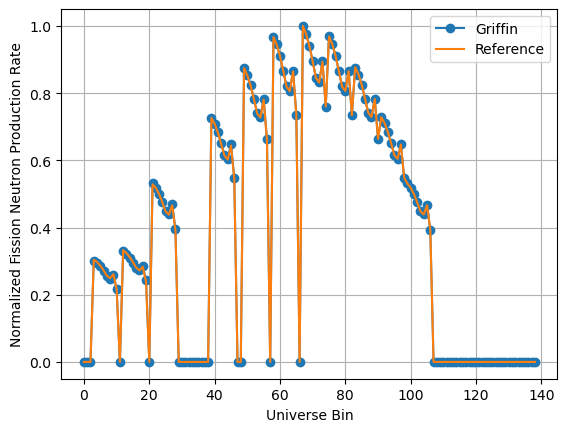

In [82]:
plt.plot(normMaximum(griffRingNuFiss), label = "Griffin", marker = "o")
plt.plot(normMaximum(ringNuFiss), label = "Reference")
plt.ylabel("Normalized Fission Neutron Production Rate")
plt.xlabel("Universe Bin")
plt.legend()
plt.grid()

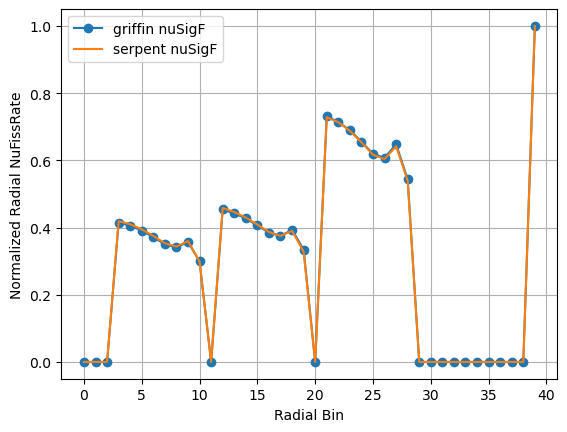

In [83]:
plt.plot(normMaximum(griffRingNuFiss[0:40]), label = "griffin nuSigF", marker = "o")
plt.plot(normMaximum(ringNuFiss[0:40]), label = "serpent nuSigF")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

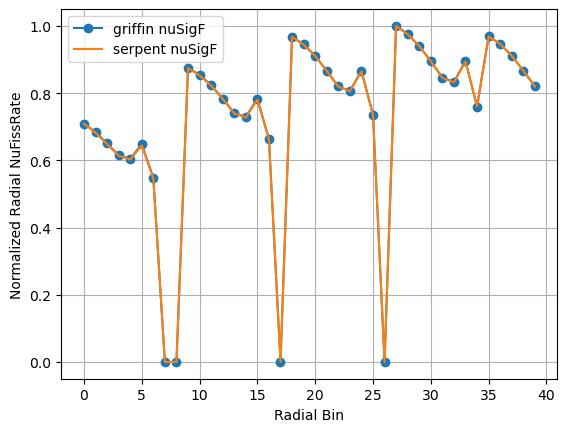

In [84]:
plt.plot(normMaximum(griffRingNuFiss[40:80]), label = "griffin nuSigF", marker = "o")
plt.plot(normMaximum(ringNuFiss[40:80]), label = "serpent nuSigF")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

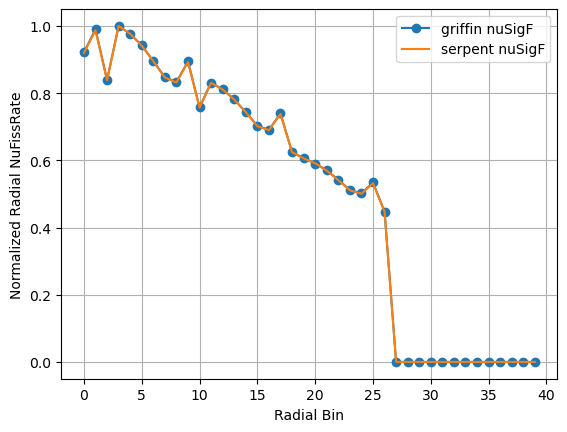

In [85]:
plt.plot(normMaximum(griffRingNuFiss[80:120]), label = "griffin nuSigF", marker = "o")
plt.plot(normMaximum(ringNuFiss[80:120]), label = "serpent nuSigF")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

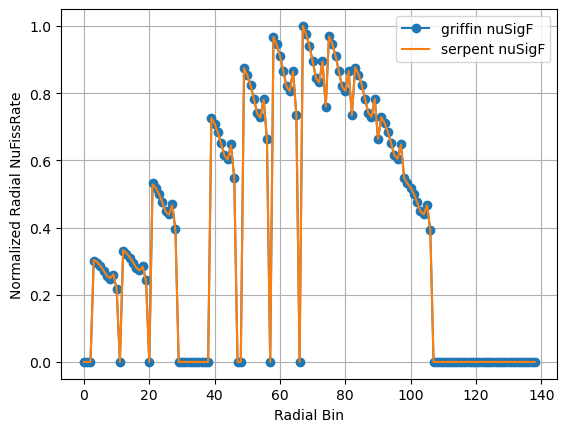

In [86]:
plt.plot(normMaximum(griffRingNuFiss), label = "griffin nuSigF", marker = "o")
plt.plot(normMaximum(ringNuFiss), label = "serpent nuSigF")
plt.ylabel("Normalized Radial NuFissRate")
plt.xlabel("Radial Bin")
plt.legend()
plt.grid()

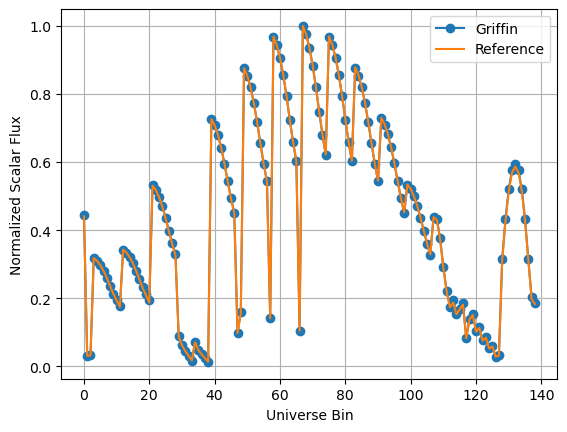

In [87]:
plt.plot(normMaximum(griffRingScalar), label = "Griffin", marker = "o")
plt.plot(normMaximum(ringCap), label = "Reference")
plt.ylabel("Normalized Scalar Flux")
plt.xlabel("Universe Bin")
plt.legend()
plt.grid()

In [88]:
ringL2NormDiffNuFiss = calcL2NormDiffPerc(normMaximum(ringNuFiss), normMaximum(griffRingNuFiss))
print("ring resolution NuFissRate l2normDiff (%): {:.3f}".format(ringL2NormDiffNuFiss))

ring resolution NuFissRate l2normDiff (%): 0.253


In [89]:
ringL2NormDiffScalar = calcL2NormDiffPerc(normMaximum(ringCap), normMaximum(griffRingScalar))
print("ring resolution ScalarFlux l2normDiff (%): {:.3f}".format(ringL2NormDiffScalar))

ring resolution ScalarFlux l2normDiff (%): 0.412


In [90]:
ringNuFissRateRelError = calcPercentRelativeError(normMaximum(ringNuFiss), normMaximum(griffRingNuFiss))
ringNuFissRateRelErrorMap = dict(zip(ringUnis, ringNuFissRateRelError))

ringScalarRelError = calcPercentRelativeError(normMaximum(ringCap), normMaximum(griffRingScalar))
ringScalarRelErrorMap = dict(zip(ringUnis, ringScalarRelError))

In [91]:
serpNuFissMap = dict(zip(ringUnis, normMaximum(ringNuFiss)))
griffNuFissMap = dict(zip(ringUnis, normMaximum(griffRingNuFiss)))

serpScalarMap = dict(zip(ringUnis, normMaximum(ringCap)))
griffScalarMap = dict(zip(ringUnis, normMaximum(griffRingScalar)))

In [92]:
errorArr = np.ones(len(ringNuFissRateRelError))*5
highErrorsIdx = np.where(ringScalarRelError > errorArr)[0]

for idx, index in enumerate(highErrorsIdx):
    print(ringUnis[index], ringScalarRelError[index])


In [93]:
maxNuFissError = np.max(ringNuFissRateRelError)
maxScalarError = np.max(ringScalarRelError)
print("max nufiss relerr (%): {:.3f}".format(maxNuFissError))
print("max total scalflux relerr (%): {:.3f}".format(maxScalarError))

max nufiss relerr (%): 1.991
max total scalflux relerr (%): 4.472


In [94]:
for uni in ringScalarRelErrorMap:
    if ringScalarRelErrorMap[uni] == maxScalarError:
        print(uni)


6900


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


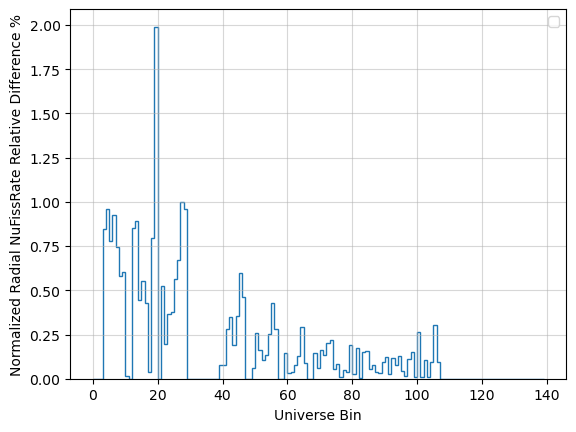

In [95]:
plt.stairs(ringNuFissRateRelError , alpha = 1)
plt.ylabel("Normalized Radial NuFissRate Relative Difference %")
plt.xlabel("Universe Bin")
plt.legend()
plt.grid(alpha = 0.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


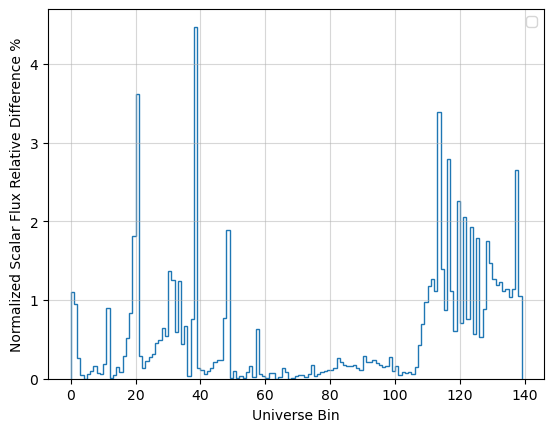

In [96]:
plt.stairs(ringScalarRelError , alpha = 1)
plt.ylabel("Normalized Scalar Flux Relative Difference %")
plt.xlabel("Universe Bin")
plt.legend()
plt.grid(alpha = 0.5)

In [97]:
def createAppendCSV(cellData, keys, params, vals, exportPath, useBlockId = False):
    xyz = ['x', 'y', 'z']

    for param in params:
        xyz.append(param)

    appendDF = pd.DataFrame(columns=xyz)

    map = {}

    for key in keys:
        for pdx, param in enumerate(params):
            map[key] = {}
            
    for kdx, key in enumerate(keys):
        for pdx, param in enumerate(params):
            map[key][param] = vals[pdx][kdx]

    
    if not useBlockId:
        pointKeys = np.array(list(cellData['material_id'])).astype('int')
    else:
        pointKeys = []
        blocks = list(cellData['Block Name'])
        for i in range(0, len(blocks)):
            pointKeys.append(int(blocks[i].replace("block_", "")))

    appendDF['x'] = list(cellData['Points_0'])
    appendDF['y'] = list(cellData['Points_1'])
    appendDF['z'] = list(cellData['Points_2'])

    for param in params:
        pointData = []
        for i in range(0, len(pointKeys)):
            pointData.append(map[str(pointKeys[i])][param])
        
        appendDF[param] = pointData

    appendDF.to_csv(exportPath, index=False)
    
    return appendDF

In [98]:
def createAppendCSVNEW(keys, maps, path):
    keys.append("matid")  
    appendDF = pd.DataFrame(columns= keys)


    for kdx, key in enumerate(keys):
        temp = []
        for matId in maps[0]:
            if key == "matid":
                #print(matId)
                temp.append(matId)
            else:
                #print(maps[kdx][matId])
                temp.append(maps[kdx][matId])
        appendDF[key] = temp
            
    appendDF.to_csv(path, index=False)
    return appendDF

In [99]:
cellDataPath = '/Users/isaacnaupaaguirre/Documents/GitHub/SNAP-REACTORS/snapReactors/reactor_models/AutomatedSerpentModels/GCU/c3_griffin/test/s83d_c2_cellDataAppend.csv'
keys = ['norm_RefnuFissRate', 'norm_griffnuFissRate', 'nuFissRateRelError', 'norm_RefscalarFlux', 'norm_griffscalarFlux', 'scalarFluxRelError']
maps = [serpNuFissMap, griffNuFissMap, ringNuFissRateRelErrorMap, serpScalarMap, griffScalarMap, ringScalarRelErrorMap]
createAppendCSVNEW(keys, maps, cellDataPath)

,norm_RefnuFissRate,norm_griffnuFissRate,nuFissRateRelError,norm_RefscalarFlux,norm_griffscalarFlux,scalarFluxRelError,matid
0,0.00000,0.00000,0.00000,0.44075,0.44560,1.09980,900
1,0.00000,0.00000,0.00000,0.03145,0.03115,0.94529,8000
2,0.00000,0.00000,0.00000,0.03215,0.03207,0.25942,7500
3,0.30404,0.30148,0.84516,0.31828,0.31811,0.05274,2100
4,0.29762,0.29477,0.95775,0.31001,0.31001,0.00033,2200
...,...,...,...,...,...,...,...
134,0.00000,0.00000,0.00000,0.51454,0.52040,1.13761,9607
135,0.00000,0.00000,0.00000,0.42731,0.43172,1.03188,9608
136,0.00000,0.00000,0.00000,0.31099,0.31454,1.14330,9609
137,0.00000,0.00000,0.00000,0.19747,0.20270,2.65212,9700
